In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from PIL import Image
from IPython.display import display
from IPython.display import Image, clear_output

In [2]:
# Load MNIST dataset
training_data, validation_data, test_data = tfds.load('MNIST', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)
print(len(training_data), len(validation_data), len(test_data))

60000 5000 5000


2024-05-11 10:29:56.460332: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-11 10:29:56.460415: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-11 10:29:56.460421: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-11 10:29:56.460524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-11 10:29:56.460560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.Tensor(4, shape=(), dtype=int64)
(28, 28, 1)


2024-05-11 10:34:40.970065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


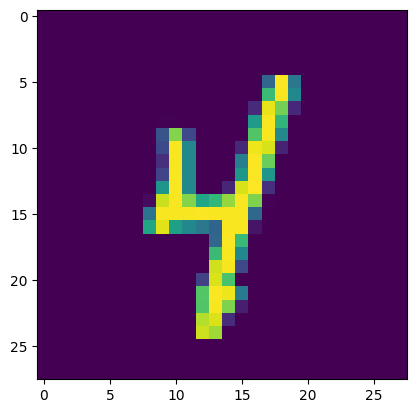

In [14]:
# Visualise the dataset
example_data = iter(training_data.take(1)).next()
plt.imshow(example_data[0])
print(example_data[1])
print(example_data[0].shape)

In [9]:
# Preprocess dataset
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return (image, label)

training_data = training_data.map(preprocess)
validation_data = validation_data.map(preprocess)
test_data = test_data.map(preprocess)

In [15]:
# Batch and shuffle dataset
training_data = training_data.shuffle(60000).batch(128)
validation_data = validation_data.batch(128)
test_data = test_data.batch(128)

In [30]:
# Simple Dense NN using Functional API for outputs of activations
inputs = tf.keras.layers.Input(shape=(28, 28, 1))
flattened = tf.keras.layers.Flatten()(inputs)
activations_1 = tf.keras.layers.Dense(units=10, activation='sigmoid')(flattened)
activations_2 = tf.keras.layers.Dense(units=10, activation='sigmoid')(activations_1)
predictions = tf.keras.layers.Dense(units=10, activation='softmax')(activations_2)
model = tf.keras.Model(inputs=inputs, outputs=[activations_1, activations_2, predictions])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                7850      
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
Total params: 8070 (31.52 KB)
Trainable params: 8070 (31.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
optimizer = tf.keras.optimizers.legacy.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [36]:
# Train model
history = model.fit(training_data, validation_data = validation_data, epochs=10)

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 1.0633 - dense_11_loss: 0.3428 - dense_12_loss: 0.3590 - dense_13_loss: 0.3615 - dense_11_accuracy: 0.9102 - dense_12_accuracy: 0.9011 - dense_13_accuracy: 0.8975 - val_loss: 1.1048 - val_dense_11_loss: 0.3552 - val_dense_12_loss: 0.3713 - val_dense_13_loss: 0.3783 - val_dense_11_accuracy: 0.9088 - val_dense_12_accuracy: 0.8950 - val_dense_13_accuracy: 0.8954
Epoch 2/10
469/469 [==============================] - 3s 5ms/step - loss: 1.0519 - dense_11_loss: 0.3402 - dense_12_loss: 0.3548 - dense_13_loss: 0.3569 - dense_11_accuracy: 0.9108 - dense_12_accuracy: 0.9025 - dense_13_accuracy: 0.9002 - val_loss: 1.1023 - val_dense_11_loss: 0.3553 - val_dense_12_loss: 0.3701 - val_dense_13_loss: 0.3769 - val_dense_11_accuracy: 0.9084 - val_dense_12_accuracy: 0.8960 - val_dense_13_accuracy: 0.8968
Epoch 3/10
469/469 [==============================] - 3s 5ms/step - loss: 1.0431 - dense_11_loss: 0.3393 - dense_12_loss: 0.3508

In [37]:
# Evaluate model on test set
model.evaluate(test_data)

40/40 [==============================] - 0s 5ms/step - loss: 1.0283 - dense_11_loss: 0.3264 - dense_12_loss: 0.3526 - dense_13_loss: 0.3492 - dense_11_accuracy: 0.9130 - dense_12_accuracy: 0.9028 - dense_13_accuracy: 0.8976


[1.028257966041565,
 0.32641512155532837,
 0.3526128828525543,
 0.3492298722267151,
 0.9129999876022339,
 0.9028000235557556,
 0.897599995136261]

In [38]:
model.save('handwriting.h5')

/Users/joshua/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
!tensorflowjs_converter \
--input_format=keras \
--output_format=tfjs_layers_model \
handwriting.h5 \
./